### Study of the bursting dynamcis of the nodes

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')
from   GDa.session           import session_info, session
from   GDa.spectral_analysis import filtering, time_frequency
from   GDa.misc.create_grids import create_stages_time_grid
import numpy             as np
import matplotlib.pyplot as plt
import scipy
from   tqdm              import tqdm

In [91]:
stages = ['baseline', 'cue', 'delay', 'match']
bands  = [r'$\theta$', r'$\alpha$', r'$\beta$', r'low-$\gamma$ ', r'high-$\gamma$' ]

In [3]:
def find_activation_sequences(spike_train):
    # make sure all runs of ones are well-bounded
    bounded = np.hstack(([0], spike_train, [0]))
    # get 1 at run starts and -1 at run ends
    difs    = np.diff(bounded)
    run_starts, = np.where(difs > 0)
    run_ends,   = np.where(difs < 0)
    act_lengths =  run_ends - run_starts  # Length of each activation sequence
    return act_lengths
    
def count_activations(spike_train):
    act_lengths = find_activation_sequences(spike_train)
    mu, sigma   = act_lengths.mean(), act_lengths.std()
    return mu, sigma, sigma/mu 

In [21]:
# Instantiate class
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,\
              slvr_msmod = False, align_to = 'cue', trial_type = 1, \
              behavioral_response = 1, evt_dt = [-0.65, 2.00])
# Read data from .mat files
ses.read_from_mat()

In [182]:
# Defining frequencies
delta = [4,8]
alpha = [8,16]
beta  = [16,40] 
low_gamma  = [40, 70]  
high_gamma = [70, 150]
bands      = [delta, alpha, beta, low_gamma, high_gamma]
freqs = np.arange(4,150,1)

# Morlet
W = time_frequency.wavelet_transform(data = ses.data, baseline_correction = False, 
                                     fs = ses.readinfo['fsample'], freqs = freqs, n_cycles = freqs/2,
                                     time_bandwidth = None, delta = 15, method = 'morlet', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   34.9s remaining:   50.6s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   41.3s remaining:   26.2s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   48.1s remaining:   10.8s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   53.2s finished


In [183]:
tarray = ses.readinfo['tarray'][::15]
print(tarray.shape)

(177,)


In [184]:
# Power spectra
S = ( W * np.conj(W) ).real

In [185]:
S = S.swapaxes(0,2).reshape(len(freqs),49,540*177)
print(S.shape)

(146, 49, 95580)


In [186]:
S_avg = np.zeros([len(bands), S.shape[1], S.shape[2]])
# Averaging over bands
for i in tqdm( range(len(bands)) ):
    band = bands[i]
    fidx = (freqs>=band[0])*(freqs<band[1])
    S_avg[i] = S[fidx,:,:].mean(axis=0)

100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


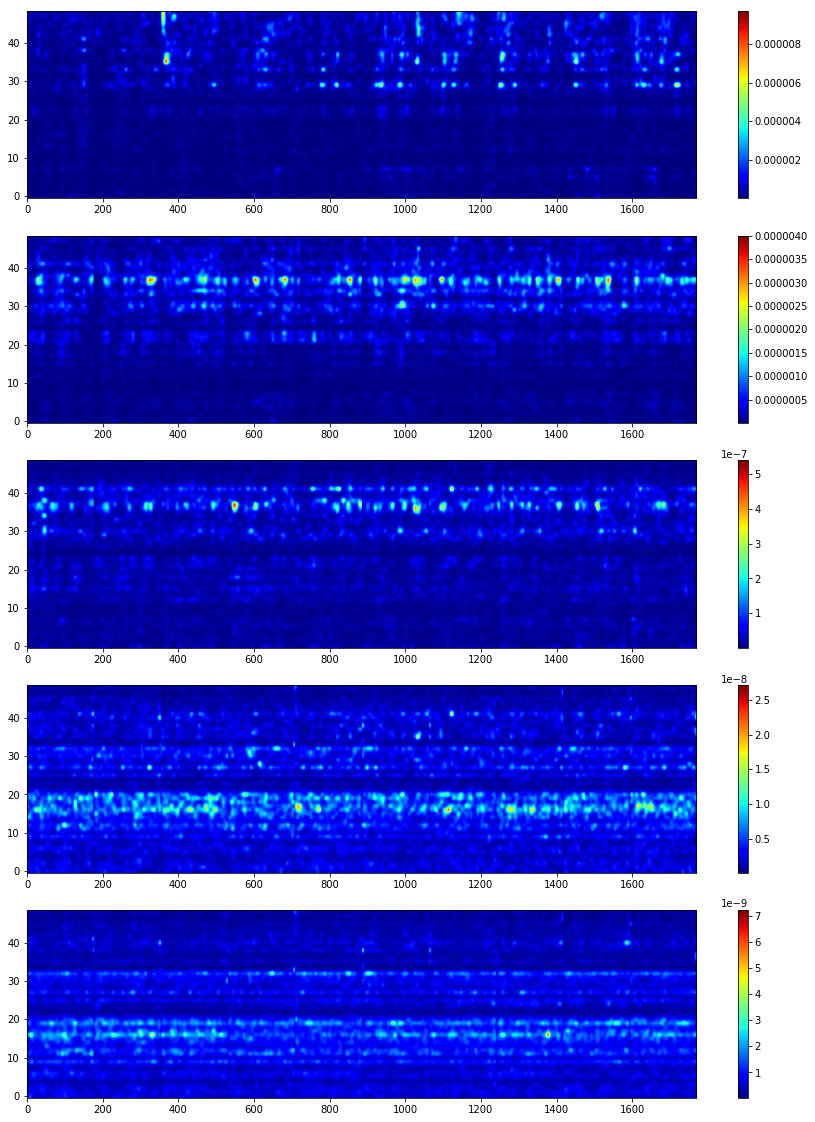

In [187]:
plt.figure(figsize=(15,20))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    plt.imshow(S_avg[i,:,:10*len(tarray)],aspect='auto',cmap='jet',origin='lower', 
               interpolation = 'gaussian')
    plt.colorbar()

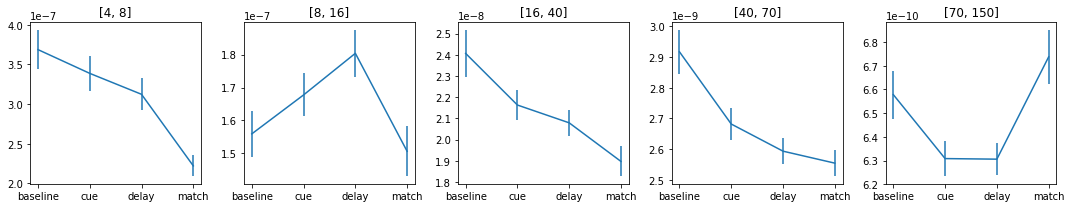

In [188]:
plt.figure(figsize=(15,3))
for j in range(len(bands)):
    mu=[]
    s =[]
    for i in range(4):
        cv = S_avg[j,:,t_mask[i]].mean(axis = -1)
        mu.append(cv.mean())
        s.append(cv.std()/np.sqrt(raster.shape[1]))
    plt.subplot(1, len(bands), j+1)
    plt.errorbar(range(4), mu, s)
    plt.xticks(range(4), stages)
    plt.title(bands[j])
plt.tight_layout()

In [235]:
raster = np.zeros_like(S_avg)
for i in tqdm( range(len(bands)) ):
    thr = scipy.stats.mstats.mquantiles(S_avg[i,:,:], prob=.90, axis=-1)
    raster[i,:,:] = S_avg[i,:,:]>thr

100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


100%|██████████| 5/5 [00:00<00:00, 79.61it/s]


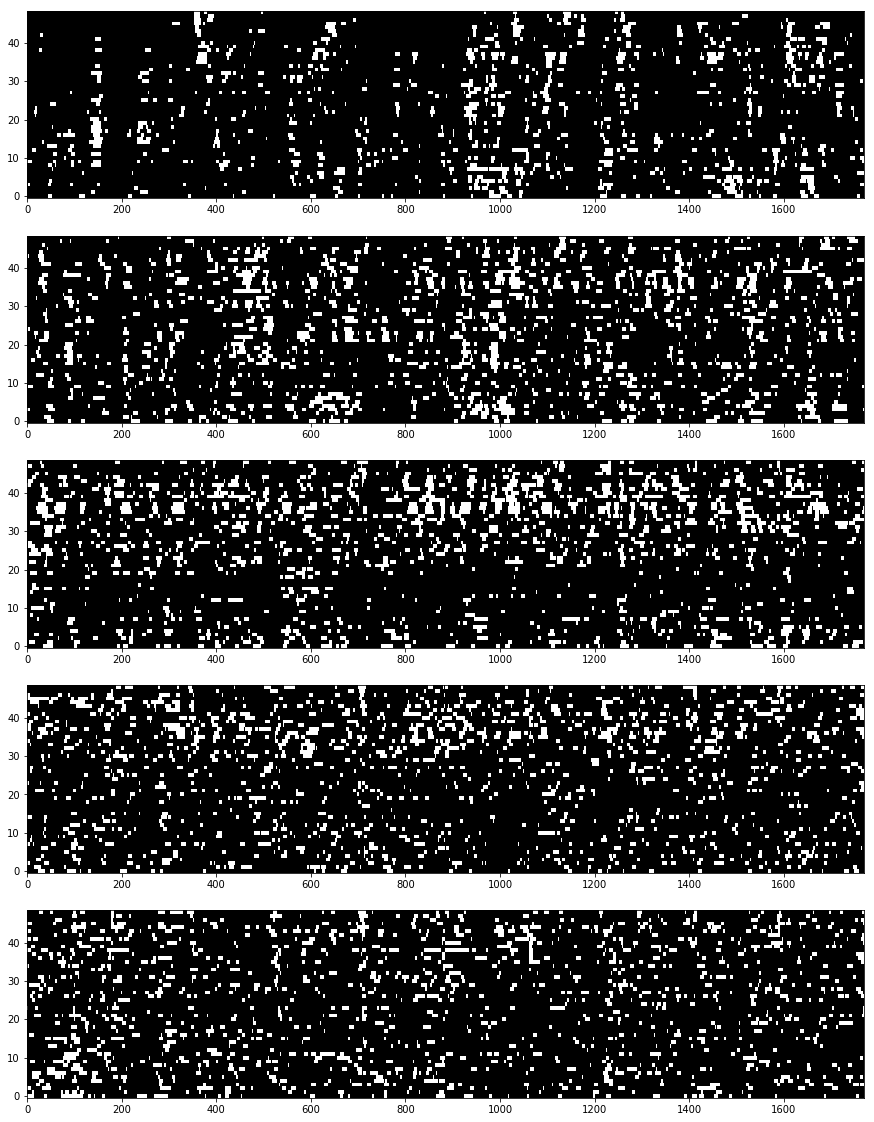

In [236]:
plt.figure(figsize=(15,20))
for i in tqdm( range(len(bands)) ):
    plt.subplot(len(bands), 1, i+1)
    plt.imshow(raster[i,:,:10*len(tarray)], aspect='auto',cmap='gray', origin='lower')

In [237]:
t_mask = create_stages_time_grid(ses.readinfo['t_cue_on'], ses.readinfo['t_cue_off'], ses.readinfo['t_match_on'], 
                                 ses.readinfo['fsample'], tarray, ses.readinfo['nT'])

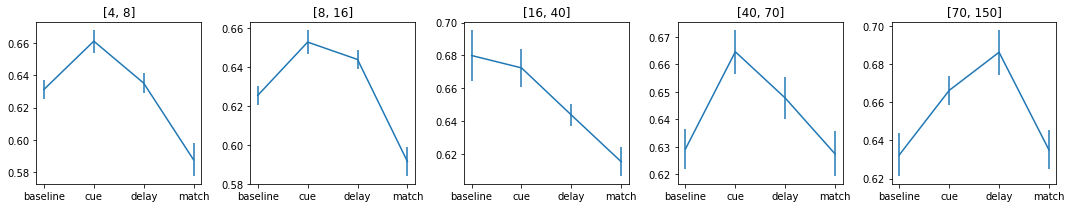

In [238]:
plt.figure(figsize=(15,3))
for j in range(len(bands)):
    mu=[]
    s =[]
    for i in range(4):
        cv = np.apply_along_axis(count_activations, 0, raster[j,:,t_mask[i]])[2,:]
        mu.append(cv.mean())
        s.append(cv.std()/np.sqrt(raster.shape[1]))
    plt.subplot(1, len(bands), j+1)
    plt.errorbar(range(4), mu, s)
    plt.xticks(range(4), stages)
    plt.title(bands[j])
plt.tight_layout()

In [239]:
nP       = int( scipy.special.comb(ses.readinfo['nC'], 2) )
# Every pair combination
i, j     = np.tril_indices(ses.readinfo['nC'], k = -1)
pairs    = np.array([j,i]).T

In [240]:
cc = np.zeros([len(stages), len(bands), ses.readinfo['nC'], ses.readinfo['nC']])
for s in tqdm( range(len(stages)) ):
    for k in range(len(bands)):
        for i, j in pairs:
            cc[s,k,i,j] = cc[s,k,j,i] = np.corrcoef(raster[k,i,t_mask[s]], raster[k,j,t_mask[s]])[0,1]#np.dot(raster[k,i,t_mask[s]], raster[k,j,t_mask[s]]) / np.sum(t_mask[s])

100%|██████████| 4/4 [00:22<00:00,  5.70s/it]


100%|██████████| 5/5 [00:00<00:00,  8.24it/s]


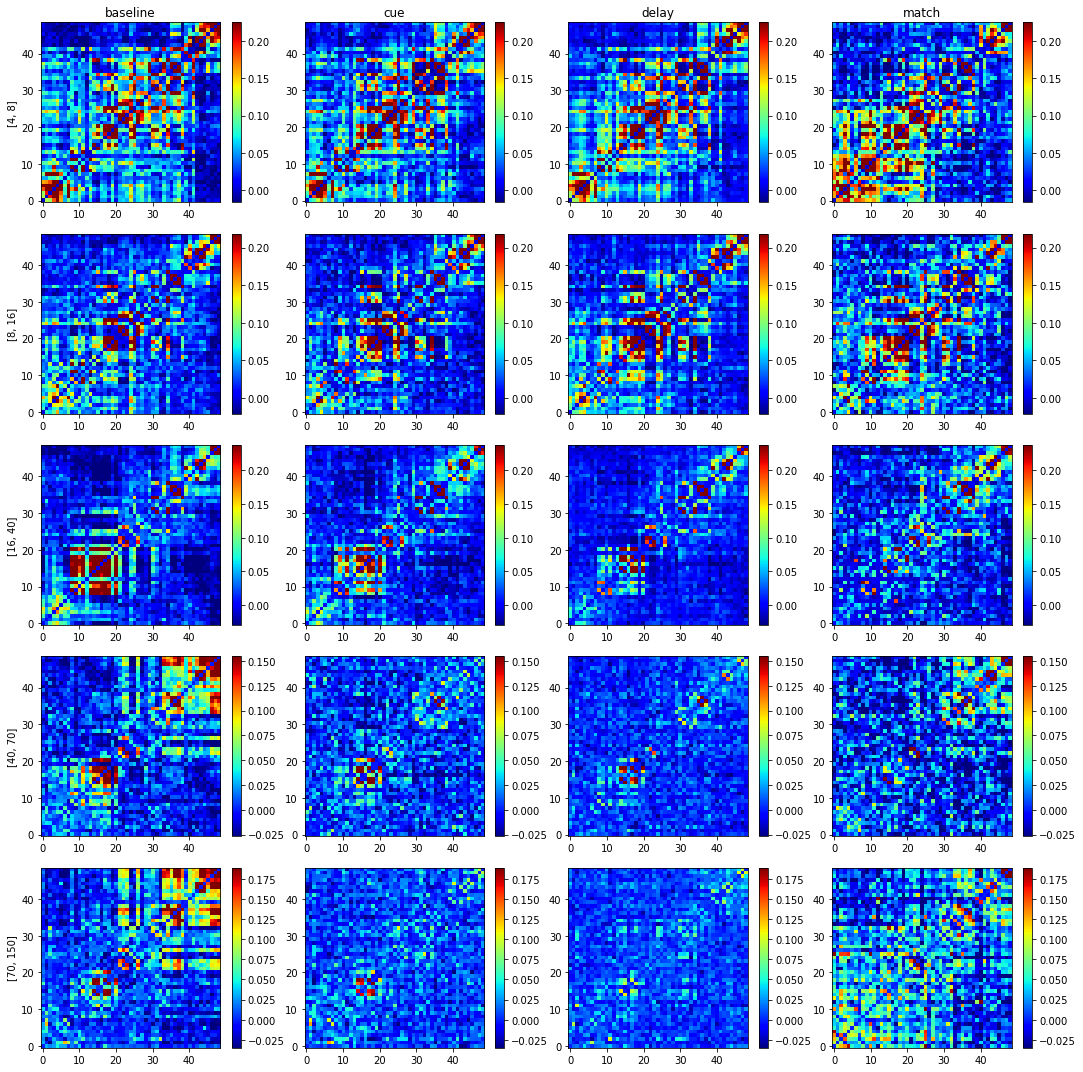

In [241]:
plt.figure(figsize=(15,15))
count = 1
for k in tqdm( range(len(bands)) ):
    for s in range(len(stages)):
            plt.subplot(len(bands), len(stages), count)
            plt.imshow(cc[s,k],aspect='auto',cmap='jet',origin='lower', vmin=cc[:,k].min()/3, vmax=cc[:,k].max()/3)
            plt.colorbar()
            if k == 0: plt.title(stages[s])
            if s == 0: plt.ylabel(bands[k])
            count+=1
plt.tight_layout()

In [242]:
cc.max()

0.7127851841793607

In [243]:
raster.shape

(5, 49, 95580)

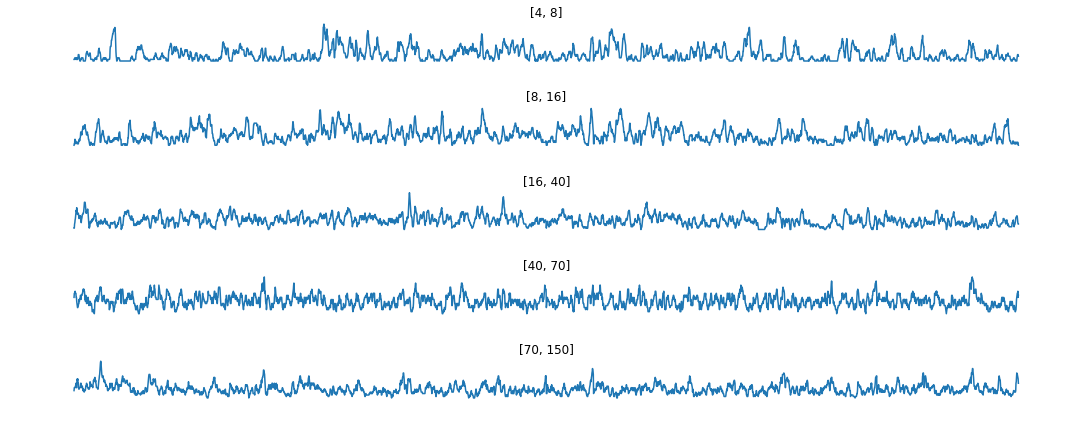

In [244]:
plt.figure(figsize=(15,6))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    rate = raster[i,:,:].sum(axis = 0)
    plt.plot(rate[:20*len(tarray)])
    plt.axis('off')
    plt.title(bands[i])
plt.tight_layout()

In [250]:
raster.shape

(5, 49, 95580)

In [246]:
rate = raster.sum(axis=1)

In [253]:
rate = raster.reshape(5,49,540,len(tarray))

In [254]:
rate.shape

(5, 49, 540, 177)

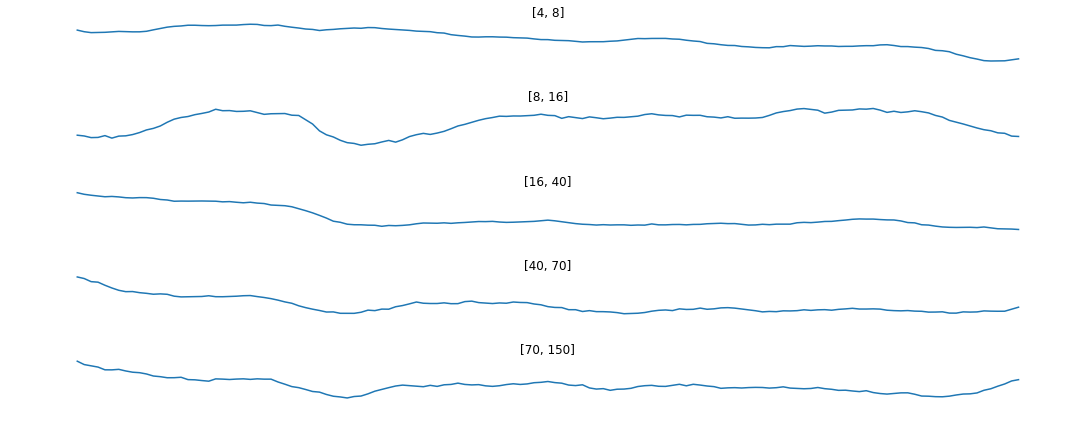

In [249]:
plt.figure(figsize=(15,6))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    plt.plot(rate[i,:,20:-20].mean(axis=0))
    plt.axis('off')
    plt.title(bands[i])
plt.tight_layout()

In [258]:
tt = np.tile(tarray, ses.readinfo['nT'])

In [261]:
raster.shape

(5, 49, 95580)

In [263]:
cv

[1677.7600029092198,
 5050.105380211031,
 -3426.735066491859,
 1172.61389054276,
 1885.2697038764315,
 -3363.5898672880444,
 -4901.733354896462,
 10304.4364874662,
 1864.0973110818272,
 1623.095415744339,
 1742.107673796441,
 2007.3273942565784,
 4288.229615213731,
 4105.394875979137,
 3041.7292392552818,
 -9867.194919671154,
 8908.061031127765,
 10347.321875730666,
 2068.1790526747413,
 12353.325105429712,
 3880.1477557845724,
 4.404578500375558e+16,
 3864.1376635724873,
 1552.943439719278,
 10379.474603136472,
 2446.093679520111,
 2716.654692706038,
 2079.7734355064117,
 2954.7361954271228,
 21512.15202298069,
 11145.291790186473,
 -3704.332621180665,
 1778.5246801352614,
 5794.283053795024,
 -102222.98071382116,
 1884.8348732614036,
 1680.1784367377368,
 1720.538299589659,
 4467.226165846585,
 6379.084019188702,
 -4641.021380471617,
 2447.7642215315973,
 2576.802280078299,
 2253.714876037299,
 2201.2991956207134,
 2351.4117708774784,
 5019.7412242407945,
 3033.793778595067,
 1856.56

In [264]:
t_spike.shape

(9558,)

In [273]:
bounded = [1,0,1,0,0,0,1,1,1]

In [277]:
    difs    = np.diff(bounded)
    run_starts, = np.where(difs > 0)
    run_ends,   = np.where(difs < 0)

In [278]:
run_starts

array([2, 7])

In [279]:
run_ends

array([1, 5])

In [280]:
difs    = np.diff(bounded)

In [283]:
raster.shape

(5, 49, 95580)

In [282]:
from sklearn.manifold import TSNE

In [293]:
Y = TSNE(n_components=2, metric='hamming', perplexity=15.0).fit_transform(raster[1,:,:30*len(tarray)].T) 

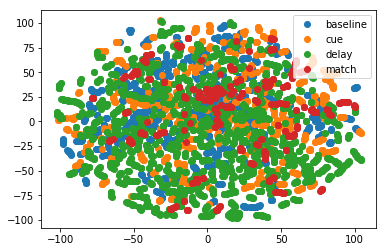

In [294]:
for i in range(len(stages)):
    plt.plot(Y[t_mask[i][:30*len(tarray)],0], Y[t_mask[i][:30*len(tarray)],1], 'o', label = stages[i])
plt.legend()